In [2]:
#IMPORT LIBRARIES
from sklearn.datasets import load_files
from keras.utils import to_categorical
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from PIL import ImageFile
from sklearn.metrics import classification_report, accuracy_score
from skimage.color import rgb2lab
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [3]:
# DEFINE FUNCTION TO LOAD TRAIN AND TEST DATASETS
def load_dataset(path):
    data = load_files(path)
    condition_files = np.array(data['filenames'])
    condition_targets = to_categorical(np.array(data['target']), 15)
    return condition_files, condition_targets

# LOAD TRAIN AND TEST DATASETS
path_org = '/content/drive/MyDrive/PatternRecognition/HW4/'
train_files, y_train = load_dataset(path_org + 'train')
test_files, y_test = load_dataset(path_org + 'test')

# LOAD LIST OF LABELS
condition_names = [item.split("/")[-2] for item in sorted(glob(path_org + 'train/*/'))]

In [4]:
#TENSOR FUNCTIONS
def path_to_tensor(img_path):
    # Loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    return x

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.stack(list_of_tensors)

#EXTRACT HOG FEATURES
def extract_hog_features(images):
    feature_list = []
    for image in images:
        # Convert the image to LAB color space
        lab_image = rgb2lab(image)
        # Extract HOG features from the L channel
        hog_features, hog_image = hog(lab_image[:, :, 0], pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), block_norm='L2',
                                      visualize=True, channel_axis=None)
        feature_list.append(hog_features)
    return np.array(feature_list)

# ONE-AGAINST-ALL SVM TRAINING FUNCTION
def train_classifier(x_train, y_train):
    svm_models = []
    for i in range(len(condition_names)):
        y_train_binary = (y_train == i).astype(int)  # Create binary labels for class i
        svm = SVC(probability=True).fit(x_train, y_train_binary)
        svm_models.append(svm)
    return svm_models

# PREDICTION FUNCTION USING ONE-AGAINST-ALL SVMS
def predict_classifier(svm_models, x_test):
    predictions = np.zeros((x_test.shape[0], len(svm_models)))
    for i, svm in enumerate(svm_models):
        predictions[:, i] = svm.predict_proba(x_test)[:, 1]  # Get probability for class i
    y_pred = np.argmax(predictions, axis=1)
    return y_pred

In [5]:
# READ IMAGES
ImageFile.LOAD_TRUNCATED_IMAGES = True

# PRE-PROCESS THE DATA
x_train = paths_to_tensor(train_files).astype('float32')
x_test = paths_to_tensor(test_files).astype('float32')

y_train = y_train.argmax(1)
y_test = y_test.argmax(1)


100%|██████████| 127/127 [00:00<00:00, 142.53it/s]


Accuracy: 0.6850393700787402


              precision    recall  f1-score   support

           0       0.62      0.78      0.69        46
           1       1.00      1.00      1.00         4
           2       1.00      0.85      0.92        13
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         4
           5       0.33      0.50      0.40         4
           6       0.50      0.50      0.50         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.73      0.73      0.73        11
          10       0.88      0.88      0.88         8
          11       1.00      0.33      0.50         3
          12       0.89      1.00      0.94         8
          13       1.00      0.62      0.77         8
          14       0.67      0.50      0.57         4

    accuracy                           0.69       127
   macro avg       0.64      0.53      0.55      

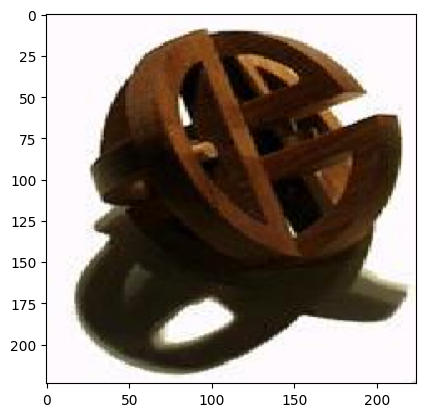

Actual class label of test sample is: BACKGROUND_Google
Predicted class label of test sample is: BACKGROUND_Google


In [6]:
# STEP 1: FEATURE EXTRACTION FOR TRAIN DATA
x_train_features = extract_hog_features(x_train)

# STEP 2: FEATURE EXTRACTION FOR TEST DATA
x_test_features = extract_hog_features(x_test)

# Normalize the HOG features
scaler = StandardScaler().fit(x_train_features)
x_train_features = scaler.transform(x_train_features)
x_test_features = scaler.transform(x_test_features)

# STEP 3: TRAIN ONE-AGAINST-ALL SVM MODELS
svm_models = train_classifier(x_train_features, y_train)

# STEP 4: MAKE PREDICTIONS
y_pred = predict_classifier(svm_models, x_test_features)

# STEP 5: COMPUTE ACCURACY
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred, zero_division=1))  # Adjust zero_division parameter

# STEP 6: MAKE PREDICTION FOR SAMPLE TEST
sample_test = x_test[0]
plt.imshow(sample_test.reshape(224, 224, 3).astype('uint8'))  # Ensure values are in the correct range
plt.show()

sample_test = np.expand_dims(sample_test, axis=0)  # Add a new axis to make it a batch of one sample

sample_test_features = extract_hog_features(sample_test)
sample_test_features = scaler.transform(sample_test_features)
y_pred_sample_test = predict_classifier(svm_models, sample_test_features)

# Print the actual and predicted labels
actual_label = condition_names[y_test[0]]
predicted_label = condition_names[y_pred_sample_test[0]]

print('Actual class label of test sample is:', actual_label)
print('Predicted class label of test sample is:', predicted_label)